# Setup and import


In [21]:
import json
import numpy as np
import random
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Tuple
import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

# For embeddings and similarity computation
try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    print("Required libraries imported successfully!")
except ImportError as e:
    print(f"Missing library: {e}")
    print("Please install with: pip install sentence-transformers scikit-learn networkx")

np.random.seed(42)

Required libraries imported successfully!


In [30]:
from scipy.sparse import find, csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import norm
from IPython.core.display import HTML

# des options permettent de limiter (ou non) le nombre de lignes/colonnes affichées
# par exemple :
# pd.set_option('display.max_rows', None)

# cette fonction permet d'afficher une "jolie" représentation du vecteur v
# ARGS :
#   v : le vecteur à afficher (par ex. une ligne de la matrice X)
#   features : le vocabulaire
#   top_n : le nombre de mots maximum à afficher
def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]})   

# fonction qui permet d'afficher plusieurs tables pandas côte à côte (c'est cadeau)
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "&emsp;"
        #output += "\xa0\xa0\xa0"
    display(HTML(output))

# 1 - Chargement et prise en main des données

In [15]:

def load_corpus(file_path: str) -> Dict[str, Dict]:
    """
    Load corpus data from JSONL file.
    Returns dictionary mapping document IDs to document data.
    """
    corpus = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():  # éviter les lignes vides
                obj = json.loads(line)
                corpus[obj["_id"]] = obj
    return corpus


def load_queries(file_path: str) -> Dict[str, Dict]:
    """
    Load query data from JSONL file.
    Returns dictionary mapping query IDs to query data.
    """
    queries = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                obj = json.loads(line)
                queries[obj["_id"]] = obj
    return queries


def load_qrels(file_path: str):
    qrels = {}
    with open(file_path, "r", encoding="utf-8") as f:
        next(f)  # sauter la ligne d'entête: query_id\tdoc_id\tscore

        for line in f:
            if not line.strip():
                continue

            qid, docid, score = line.strip().split('\t')
            score = int(score)

            if qid not in qrels:
                qrels[qid] = {}

            qrels[qid][docid] = score

    return qrels



In [16]:
#Fonction test
print("Loading dataset...")
corpus = load_corpus('dataset_BE2/corpus.jsonl')
queries = load_queries('dataset_BE2/queries.jsonl')
qrels_valid = load_qrels('dataset_BE2/valid.tsv')

print(f"Loaded {len(corpus)} documents in corpus")
print(f"Loaded {len(queries)} queries")
print(f"Loaded relevance for {len(qrels_valid)} queries (dataset)")

Loading dataset...
Loaded 25657 documents in corpus
Loaded 1000 queries
Loaded relevance for 700 queries (dataset)


# 2 - Exploration des données et premier encodage

### Statistiques générales

In [20]:
nb_docs = len(corpus)
nb_queries = len(queries)
nb_pairs = sum(len(docs) for docs in qrels_valid.values()) #on prend chaque dictionnaire de documents pour chaque requête et on somme
proportions = []
for qid, docs in qrels_valid.items(): ##[..].items contient une ligne par requête avec id de chaque document et score
    total_docs = len(docs)
    if total_docs == 0:
        continue  # éviter division par zéro
    num_positifs = sum(1 for score in docs.values() if score == 1)
    proportion = num_positifs / total_docs
    proportions.append(proportion)

moyenne_proportion = sum(proportions) / len(proportions)

print(f"Taille du corpus : {nb_docs} documents")
print(f"Nombre de requêtes : {nb_queries}")
print(f"Nombre total de paires requête/document : {nb_pairs}")
print(f"Proportion d'articles pertinents par requète : {round(moyenne_proportion*100)}%")


Taille du corpus : 25657 documents
Nombre de requêtes : 1000
Nombre total de paires requête/document : 20950
Proportion d'articles pertinents par requète : 16%


In [23]:
##Exemple de requète 

# Choisir une requête au hasard
qid, docs = random.choice(list(qrels_valid.items()))

# Récupérer le texte de la requête (ici, juste le titre)
query_title = queries[qid]['text']

# Séparer les documents positifs et négatifs
positive_docs = [docid for docid, score in docs.items() if score == 1]
negative_docs = [docid for docid, score in docs.items() if score == 0]

# Limiter à 3 exemples pour l'affichage
positive_examples = positive_docs[:3]
negative_examples = negative_docs[:3]

print(f"Exemple de requête ({qid}): {query_title}\n")
print("Exemples de documents positifs :")
for docid in positive_examples:
    print(f"- {corpus[docid]['title']}")

print("\nExemples de documents négatifs :")
for docid in negative_examples:
    print(f"- {corpus[docid]['title']}")


Exemple de requête (0963302a589b5476df76040ab22a3315e0f84bb1): Lire: lucene image retrieval: an extensible java CBIR library

Exemples de documents positifs :
- CEDD: Color and Edge Directivity Descriptor: A Compact Descriptor for Image Indexing and Retrieval
- Textural Features Corresponding to Visual Perception
- Normalized cuts in 3-D for spinal MRI segmentation

Exemples de documents négatifs :
- Homography-based 2D Visual Tracking and Servoing
- A compact printed monopole antenna with symmetrical i and rectangular shaped slots for bluetooth/WLAN/WIMAX applications
- Pruning ConvNets Online for Efficient Specialist Models


### Premier encodage des données

On va maintenant créer une matrice de dimension (n,m) avec n le nombre de documents du corpus et m le nombre de termes différents qui apparaissent dans tous les titres de tous les articles de tout le corpus. Les valeurs contenues dans X(i,j) seront alors le nombre d'occurence du mot j dans le document i. 

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# Récupérer les titres de tous les documents du corpus
titles = [doc['title'] for doc in corpus.values()]

# Créer le vecteur compteur
vectorizer = CountVectorizer()  # paramètres par défaut pour l'instant

# Construire le vocabulaire et transformer les titres en matrice Documents x Termes
X = vectorizer.fit_transform(titles)

# X est maintenant une matrice creuse (sparse) de taille (n_documents, n_mots)
print(f"Nombre de documents : {X.shape[0]}")
print(f"Nombre de termes : {X.shape[1]}")

# Exemple : récupérer le vocabulaire
vocab = vectorizer.get_feature_names_out()
print(f"Exemples de termes (10 premières colonnes de la matrice): {vocab[:10]}")


Nombre de documents : 25657
Nombre de termes : 20075
Exemples de termes (10 premières colonnes de la matrice): ['00' '000' '00058' '001' '0016' '002' '003' '0031' '004' '01']


On observe ici que des termes sous forme de numéro. Il y a donc nécessité de faire du prétraitement pour avoir une matrice plus dense et donc plus facilement utilisable.

### Exemples de vecteurs de X

Pour voir différents vecteurs, vous pouvez run plusieurs fois la cellule ci-dessous.

In [41]:
v = X[random.randint(1,X.shape[0])] 
df_feats = print_feats(v, vocab, top_n=30)
print(df_feats)

           word  value
0            an      1
1     animation      1
2         child      1
3     education      1
4  experimental      1
5         study      1
6       through      1


### Fréquences d'occurence des mots dans le corpus 

On affiche ici l'histogramme des 30 mots les plus fréquents dans le corpus (en titre)

              word  value
0               of   8911
1              and   8551
2              for   8090
3               in   5103
4              the   4887
5             with   2647
6               on   2558
7            based   2538
8            using   2483
9               to   2261
10        learning   1902
11              an   1633
12            data   1406
13        networks   1282
14        analysis   1254
15       detection   1168
16          system   1044
17          neural   1015
18            from   1014
19            deep    861
20         network    825
21           model    817
22         systems    815
23     recognition    807
24          design    786
25        approach    754
26              by    694
27           image    680
28  classification    660
29         control    626


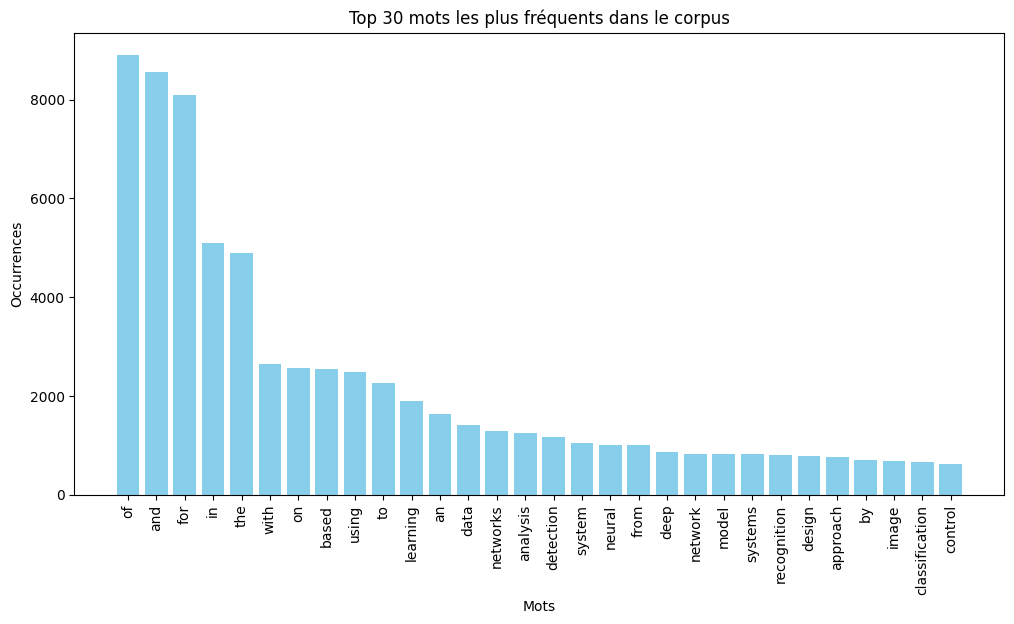

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Somme des occurrences par colonne (mot)
word_counts = np.array(X.sum(axis=0)).flatten()  # .flatten() pour obtenir un vecteur 1D

# On utilise print_feats pour voir les mots les plus fréquents
top_words_df = print_feats(X.sum(axis=0), vocab, top_n=30)
print(top_words_df)

plt.figure(figsize=(12,6))
plt.bar(top_words_df["word"], top_words_df["value"], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Mots")
plt.ylabel("Occurrences")
plt.title("Top 30 mots les plus fréquents dans le corpus")
plt.show()